# Predict volume from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
traindf = preprocessor.train_df.copy()

In [5]:
preprocessor.train_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,0
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,0
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,0
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,0
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,0


In [6]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col=['v'], path=data_path/'AV_las/', 
                                                     min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=True, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True,
                                                     log_y=False)

100%|██████████| 225/225 [00:09<00:00, 23.61it/s]


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [7]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

Check the distribution of the target variable `g`, in order to get limits for `sigmoid_range`.

In [8]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [9]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [10]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [11]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,1000))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 69'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 69              138        True      
________________________________________________________________
BatchNorm1d          64 x 69              138        True      
________________________________________________________________
Linear               64 x 200             13,800     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.001737800776027143)

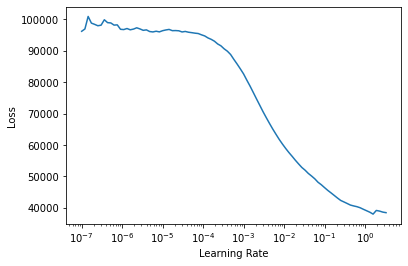

In [12]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,87634.109375,89019.781250,298.361816,197.893829,282.535950,187.397049,285.293823,-8.781532,00:00
1,68366.515625,39511.156250,198.774139,131.840515,179.140320,118.818024,185.491135,-3.341503,00:00
2,45150.542969,6707.695312,81.900520,54.321991,48.423035,32.117447,69.522758,0.262956,00:00
3,29089.666016,2338.129639,48.354210,32.071796,7.206385,4.779764,33.343441,0.743085,00:00
4,19746.080078,2082.141602,45.630493,30.265245,5.187772,3.440883,30.875031,0.771213,00:00
5,13873.023438,1637.148560,40.461693,26.836945,6.174059,4.095055,27.270258,0.820109,00:00
6,10019.792969,1660.095947,40.744278,27.024374,9.414435,6.244293,27.359295,0.817588,00:00
7,7434.052246,1718.399414,41.453583,27.494833,9.159378,6.075122,27.482212,0.811182,00:00
8,5643.129395,1642.273926,40.524979,26.878920,11.082092,7.350397,25.715361,0.819546,00:00
9,4365.481445,1776.379395,42.147114,27.954828,14.205564,9.422095,28.374578,0.804811,00:00


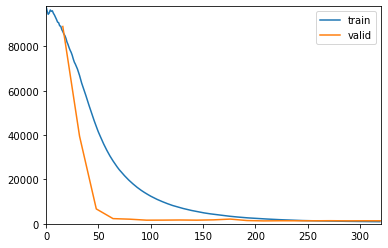

In [13]:
learn.fit_one_cycle(20, max_lr=1e-2, cbs=ShowGraphCallback())

In [14]:
preds, true = learn.get_preds()

In [15]:
preds.shape

torch.Size([225, 1])

See validation results

In [16]:
learn.validate()

(#7) [1362.998046875,36.918800354003906,24.487056732177734,6.823336124420166,4.525700092315674,24.4775333404541,0.8502331937692138]

`RegressionInterpretation` can be used to plot results.

In [17]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

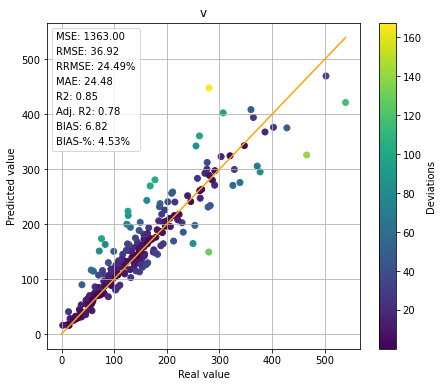

In [18]:
reg_interp.plot_results()
plt.show()

Evaluate test set.

In [19]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [20]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

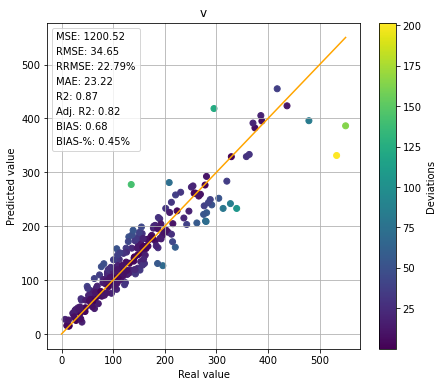

In [21]:
test_interp.plot_results()
plt.show()

In [25]:
import random
point_clouds = os.listdir(data_path/'AV_las')
cloud = random.sample(point_clouds, 1)
data = process_one(data_path/'AV_las'/cloud[0])

In [26]:
learn.predict(data)[-1]

tensor([281.9370])

# Ensemble of ANNs

Fit several models at once.

In [27]:
ensemble = Ensemble(dls, learn_func=tabular_learner,
                    y_range=(0,trainval_tb.y.max() * 1.1), 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [28]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,89515.812500,86065.976562,293.370026,194.582947,279.098785,185.117279,280.741699,-8.456966,00:00
1,70186.351562,38897.527344,197.224564,130.812729,180.066544,119.432365,183.127411,-3.274077,00:00
2,46825.621094,7189.822266,84.792816,56.240356,43.775318,29.034765,69.336693,0.209979,00:00
3,30425.396484,2369.978271,48.682423,32.289490,1.968868,1.305887,35.664341,0.739586,00:00
4,20661.802734,1999.054443,44.710785,29.655230,6.648759,4.409909,31.483772,0.780343,00:00
5,14521.047852,1943.092651,44.080524,29.237198,0.707432,0.469217,30.624546,0.786492,00:00
6,10545.029297,2099.117188,45.816124,30.388367,-4.636884,-3.075496,31.752916,0.769348,00:00
7,7788.964844,1380.065430,37.149231,24.639894,2.069446,1.372597,26.014471,0.848358,00:00
8,5872.595703,1479.594482,38.465496,25.512930,7.694909,5.103786,26.155462,0.837422,00:00
9,4522.255371,1376.691406,37.103794,24.609758,5.649635,3.747222,25.215775,0.848729,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,94233.617188,94473.437500,307.365326,203.865570,297.055450,197.027359,297.094269,-9.380783,00:00
1,75241.187500,43778.699219,209.233597,138.777939,194.959412,129.310333,196.450684,-3.810422,00:00
2,50611.046875,8522.767578,92.318840,61.232124,49.455734,32.802402,76.117416,0.063515,00:00
3,32992.519531,2914.578857,53.986839,35.807739,16.364017,10.853728,38.704521,0.679745,00:00
4,22450.238281,1931.349976,43.947128,29.148722,2.804733,1.860289,32.254025,0.787782,00:00
5,15874.320312,1792.215942,42.334572,28.079165,3.342524,2.216989,30.224783,0.803071,00:00
6,11501.413086,1560.196533,39.499325,26.198635,2.079373,1.379181,28.167196,0.828565,00:00
7,8500.837891,1716.086060,41.425671,27.476320,10.756015,7.134120,27.918972,0.811436,00:00
8,6437.888184,1530.315674,39.119251,25.946545,-0.269195,-0.178548,26.449146,0.831848,00:00
9,4931.074219,1496.988770,38.690941,25.662460,8.003809,5.308670,26.318804,0.835510,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,92748.789062,87588.265625,295.953156,196.296234,280.982025,186.366379,282.677399,-8.624237,00:00
1,73019.007812,40954.148438,202.371307,134.226410,186.288269,123.559036,188.626129,-3.500059,00:00
2,48652.464844,7987.567383,89.373192,59.278374,47.746689,31.668848,74.282372,0.122323,00:00
3,31664.158203,3393.389648,58.252808,38.637222,6.199754,4.112098,39.453968,0.627133,00:00
4,21558.876953,2455.297852,49.550961,32.865562,-0.802262,-0.532115,33.915321,0.730211,00:00
5,15176.977539,1861.746094,43.147953,28.618654,0.729665,0.483964,30.098391,0.795431,00:00
6,10987.855469,2941.439453,54.235039,35.972363,15.016914,9.960238,32.808437,0.676793,00:00
7,8214.126953,1622.717773,40.282970,26.718403,3.792063,2.515153,27.020681,0.821695,00:00
8,6213.934570,1650.316650,40.624088,26.944654,6.219932,4.125481,26.849642,0.818662,00:00
9,4806.686035,1605.672974,40.070850,26.577711,9.088121,6.027860,25.828413,0.823568,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,119199.882812,108471.539062,329.350189,218.447418,317.416656,210.532303,317.776978,-10.918900,00:00
1,96183.257812,56524.890625,237.749634,157.691711,224.491135,148.897766,225.685349,-5.210979,00:00
2,66259.007812,12090.783203,109.958099,72.931686,66.161911,43.883072,92.762978,-0.328541,00:00
3,43222.546875,3419.025635,58.472435,38.782890,18.824003,12.485357,44.357063,0.624316,00:00
4,29168.476562,2298.280518,47.940384,31.797319,-1.256252,-0.833231,35.210274,0.747464,00:00
5,20397.164062,1987.445312,44.580772,29.568996,-0.060932,-0.040414,32.550144,0.781619,00:00
6,14616.388672,1775.157227,42.132614,27.945211,-4.003123,-2.655143,29.966692,0.804945,00:00
7,10717.909180,1796.671631,42.387161,28.114044,-1.601528,-1.062242,29.883501,0.802581,00:00
8,8051.545410,1671.797485,40.887619,27.119446,-4.222292,-2.800511,29.189270,0.816302,00:00
9,6120.775879,1539.305054,39.233974,26.022636,8.713781,5.779572,26.480772,0.830861,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,104641.101562,97466.773438,312.196686,207.070068,294.239136,195.159393,297.566528,-9.709691,00:00
1,82633.390625,49144.816406,221.686295,147.037415,205.475983,136.285629,208.250626,-4.400054,00:00
2,55618.347656,9325.059570,96.566345,64.049362,55.125027,36.562660,81.509903,-0.024642,00:00
3,36075.714844,3124.689209,55.898918,37.075962,19.014771,12.611888,38.578373,0.656658,00:00
4,24464.974609,2869.522461,53.567924,35.529888,10.390469,6.891665,33.416988,0.684696,00:00
5,17165.474609,1643.589844,40.541210,26.889685,3.004503,1.992791,27.656803,0.819402,00:00
6,12331.978516,1522.779907,39.022808,25.882578,2.567528,1.702959,26.347332,0.832676,00:00
7,9065.961914,2027.678589,45.029755,29.866795,-4.904449,-3.252964,28.694120,0.777198,00:00
8,6812.730469,1404.844604,37.481255,24.860115,1.981159,1.314039,25.186474,0.845635,00:00
9,5222.991699,1573.678833,39.669621,26.311588,6.811897,4.518113,26.697969,0.827083,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,127058.921875,110655.226562,332.648804,220.635300,320.559204,212.616638,320.559204,-11.158844,00:00
1,101413.750000,56037.000000,236.721359,157.009689,222.452316,147.545502,222.765198,-5.157370,00:00
2,68921.500000,12669.999023,112.561089,74.658165,67.852791,45.004581,94.694153,-0.392185,00:00
3,45041.601562,3590.352783,59.919556,39.742722,19.284306,12.790662,44.446529,0.605490,00:00
4,30302.945312,2289.181152,47.845387,31.734312,-0.231619,-0.153626,34.088608,0.748464,00:00
5,21219.373047,2092.003418,45.738422,30.336830,-1.074558,-0.712720,31.947283,0.770130,00:00
6,15269.016602,1921.010376,43.829338,29.070595,-2.181914,-1.447193,30.185690,0.788919,00:00
7,11206.500977,1477.918701,38.443710,25.498480,2.702311,1.792356,26.766966,0.837606,00:00
8,8371.166016,1510.748291,38.868343,25.780127,0.051292,0.034020,27.185165,0.833998,00:00
9,6379.555176,1490.760132,38.610363,25.609016,9.378031,6.220147,26.442688,0.836195,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,116855.421875,107393.179688,327.708984,217.358871,317.121979,210.336838,317.121948,-10.800409,00:00
1,94253.812500,55191.269531,234.928238,155.820374,220.756088,146.420441,222.339447,-5.064441,00:00
2,63823.406250,11079.467773,105.259048,69.814949,67.319870,44.651112,89.007538,-0.217417,00:00
3,41223.964844,2509.815186,50.098057,33.228436,10.891001,7.223652,37.320591,0.724220,00:00
4,27816.931641,1907.016724,43.669403,28.964516,-2.440410,-1.618646,31.149021,0.790456,00:00
5,19400.031250,1990.027100,44.609718,29.588196,12.823172,8.505198,31.654228,0.781335,00:00
6,13946.725586,2332.281738,48.293701,32.031666,16.751030,11.110421,32.525101,0.743728,00:00
7,10184.523438,1638.196899,40.474648,26.845535,-0.234020,-0.155218,28.442396,0.819994,00:00
8,7594.387695,1433.049194,37.855637,25.108429,2.127295,1.410967,26.841024,0.842536,00:00
9,5829.305664,1418.893066,37.668194,24.984104,1.426501,0.946152,26.735174,0.844091,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,118308.835938,110522.984375,332.449982,220.503418,321.487671,213.232468,321.559387,-11.144313,00:00
1,93846.625000,51304.718750,226.505447,150.233810,208.692642,138.419144,210.492813,-4.637385,00:00
2,62820.277344,9506.703125,97.502327,64.670166,53.206821,35.290379,81.503899,-0.044601,00:00
3,40586.500000,2485.875488,49.858555,33.069580,4.081828,2.707346,35.371258,0.726851,00:00
4,27363.306641,2165.102051,46.530659,30.862295,0.659797,0.437622,32.215076,0.762098,00:00
5,19104.677734,1826.029541,42.732067,28.342810,-1.762699,-1.169142,29.235409,0.799355,00:00
6,13741.374023,1738.490723,41.695213,27.655098,4.990839,3.310264,28.272741,0.808974,00:00
7,10098.284180,2318.997559,48.155972,31.940311,-6.306388,-4.182826,33.023663,0.745188,00:00
8,7591.491699,1594.365967,39.929512,26.483965,1.199561,0.795630,26.935606,0.824810,00:00
9,5729.487793,1742.003052,41.737312,27.683023,10.318053,6.843634,27.922491,0.808588,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,138496.906250,117716.125000,343.097809,227.565796,330.534119,219.232681,330.800293,-11.934697,00:00
1,111609.203125,61029.742188,247.041992,163.855042,233.393677,154.802536,234.996582,-5.705974,00:00
2,76810.914062,13465.390625,116.040466,76.965919,80.470818,53.373711,99.964844,-0.479583,00:00
3,50086.105469,3274.891357,57.226669,37.956615,14.651754,9.718039,42.872517,0.640154,00:00
4,33657.082031,2208.180908,46.991287,31.167814,1.134542,0.752506,33.389011,0.757364,00:00
5,23400.980469,1969.857544,44.383076,29.437872,8.098049,5.371177,31.249674,0.783551,00:00
6,16747.615234,1761.153564,41.966103,27.834770,10.815289,7.173434,28.732363,0.806484,00:00
7,12214.102539,1491.156616,38.615498,25.612423,2.760583,1.831006,26.665291,0.836151,00:00
8,9050.786133,1360.966431,36.891277,24.468801,1.597319,1.059450,24.708513,0.850456,00:00
9,6845.739258,1491.849487,38.624466,25.618372,9.182044,6.090156,25.678947,0.836075,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,103930.445312,96786.914062,311.105957,206.346603,298.523743,198.001236,298.849884,-9.634988,00:00
1,83198.671875,48055.574219,219.215820,145.398834,202.344086,134.208344,205.330597,-4.280367,00:00
2,56101.968750,9667.546875,98.323685,65.214951,59.729710,39.616802,82.022636,-0.062274,00:00
3,36257.949219,3545.183838,59.541443,39.491932,14.229820,9.438184,40.431065,0.610454,00:00
4,24465.298828,2527.010742,50.269382,33.342068,8.139390,5.398597,33.930504,0.722331,00:00
5,17136.095703,2125.223389,46.100143,30.576748,-3.042352,-2.017894,31.047863,0.766480,00:00
6,12330.176758,1963.321167,44.309380,29.388990,2.668628,1.770016,29.669159,0.784269,00:00
7,9036.506836,1676.928345,40.950317,27.161032,10.819353,7.176130,27.590515,0.815738,00:00
8,6789.705566,1820.935547,42.672421,28.303247,3.192635,2.117573,27.764139,0.799915,00:00
9,5154.957031,1546.273926,39.322693,26.081482,6.215020,4.122223,26.094353,0.830095,00:00


In [29]:
res = ensemble.validate()

See ensemble validation results.

In [30]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,35.573082,23.594484,6.259712,4.151866,23.344149,0.860952
1,0,37.636856,24.963322,9.834141,6.522670,25.306782,0.844351
2,1,38.127293,25.288612,7.684015,5.096561,25.184189,0.840268
3,2,36.640190,24.302263,3.420817,2.268919,23.802197,0.852485
4,3,36.143429,23.972778,6.102806,4.047796,24.616571,0.856458
5,4,39.198975,25.999424,6.412484,4.253195,25.685638,0.831162
6,5,37.145786,24.637609,4.292082,2.846800,25.213779,0.848386
7,6,36.357853,24.114998,6.282040,4.166676,25.428331,0.854750
8,7,39.631889,26.286564,8.144154,5.401756,26.134230,0.827412
9,8,35.082668,23.269209,3.235696,2.146133,22.990963,0.864760


In [31]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

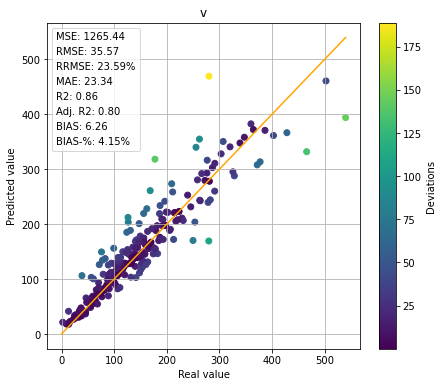

In [32]:
ens_int.plot_results()
plt.show()

Run test set predictions.

In [33]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,33.277470,21.891108,0.561262,0.369218,22.045004,0.882324
1,0,32.487679,21.371555,3.003619,1.975888,22.854969,0.887843
2,1,35.194695,23.152327,1.120927,0.737386,23.179588,0.868374
3,2,34.157291,22.469885,-1.552843,-1.021516,22.529623,0.876019
4,3,35.886009,23.607098,-0.024826,-0.016332,24.711864,0.863152
5,4,35.229588,23.175280,2.403206,1.580914,23.355381,0.868112
6,5,37.189064,24.464294,-1.861331,-1.224450,24.601080,0.853033
7,6,35.453430,23.322531,2.630891,1.730694,23.995615,0.866431
8,7,36.179817,23.800377,1.536444,1.010728,24.732407,0.860902
9,8,36.587360,24.068472,-2.585790,-1.701025,24.138922,0.857750


In [34]:
run_test_res = test_res[test_res.model_identifier != 'ensemble']

In [35]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

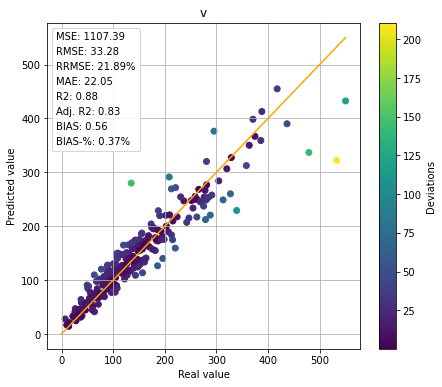

In [36]:
test_ens_interp.plot_results()
plt.show()

In [37]:
e_preds = [m.predict(data)[-1] for m in ensemble.models]
e_preds

[tensor([243.8719]),
 tensor([302.1786]),
 tensor([188.9737]),
 tensor([293.0073]),
 tensor([253.7103]),
 tensor([327.9385]),
 tensor([345.9340]),
 tensor([297.9222]),
 tensor([292.2241]),
 tensor([344.2461])]

In [38]:
ensemble.predict(data)[-1]

tensor([289.0007])

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [35]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [36]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [37]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [38]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

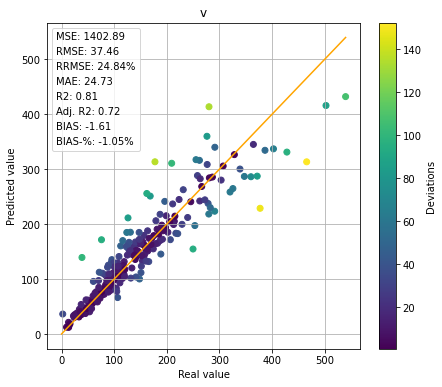

In [39]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

Test results

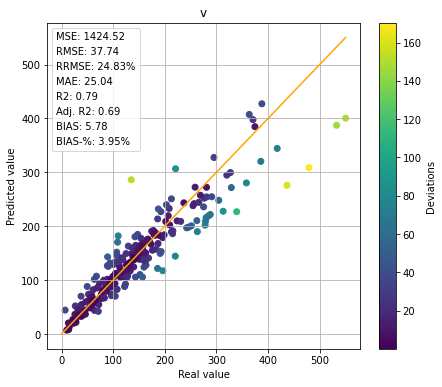

In [40]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()